# Visualize age bands corresponding to RI study

* TODO: Filter for rehab patients

In [44]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import data_utils as util

import seaborn as sns

import sys
sys.path.append('../')

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
demo_df = pd.read_excel('../data/demographics and Biologics data.xlsx', index_col=0)
demo_ids = demo_df.index.values
demo_df.head()

,patient_gender_id,patient_date_of_diagnosis,Age at diagnosis,patient_hla_bUnknown7_id,EIBP,patient_condition_subtype,Current biologic,Number of biologics used (not including brand/biosimilar switch),year of Birth
patient_id,,,,,,,,,
40,Female,1994-01-01,46.255989,Positive,False,AS,Infliximab,1,1947
41,Male,2003-01-01,46.644764,Positive,False,AS,Adalimumab,1,1956
43,Male,1978-01-01,20.410678,Positive,False,AS,Adalimumab,1,1957
44,Male,1994-01-01,22.047912,Unknown,False,AS,Adalimumab,1,1971
45,Male,1998-01-01,37.048597,Positive,False,AS,Etanercept,1,1960


In [19]:
df = pd.read_excel('../data/clean_basmi.xls', index_col=(0,1))
df.head()

CRS  TWS  LSFS  LFS  IMS   BS Drug
patient_id Date                                          
40         1995-05-09    3    1     6    5    3  3.6  NaN
           1995-06-01    3    1     8    5    3  4.0  NaN
           1995-06-12    2    1     5    3    2  2.6  NaN
           1995-11-02    1    1     3    4    2  2.2  NaN
           1996-05-02    2    1     4    3    2  2.4  NaN

In [40]:
print_ = False

no_drugs_dfs = []
drugs_dfs = []
i = 0
for patient_id, patient_df in df.groupby('patient_id'):
    
    # if we don't have demographic info, skip this patient
    if patient_id not in demo_ids:
        continue
        
    # Add the patient age column
    patient_yob = demo_df.loc[patient_id]['year of Birth']
    
    dates = pd.to_datetime(patient_df.index.get_level_values('Date'))
    
    age = [d.year - patient_yob for d in dates]
    
    patient_df['Age'] = age
    
    no_drugs_df = patient_df[patient_df['Drug'].isnull()]
    drugs_df = patient_df.dropna(how='any')
    
    if print_:
        print(patient_id,'\n')
        print('No Drugs:')
        print(no_drugs_df)
        print('\nDrugs:')
        print(drugs_df)
        print('\n\n')

    # Start date of periods for which patient took biologics
    drugs_dates = drugs_df.index.get_level_values('Date')
    no_drugs_dates = no_drugs_df.index.get_level_values('Date')
    
    drugs_start = min(drugs_dates) if not drugs_dates.empty else None
    no_drugs_start = min(no_drugs_dates) if not no_drugs_dates.empty else None
        
    # if a patient used drugs and then stopped, skip this patient
    if drugs_start and no_drugs_start and drugs_start < no_drugs_start:
        print('patient {} had invalid data'.format(patient_id))
        continue
        
    # If patient had taken drugs, save the data
    if not drugs_df.empty:
        drugs_dfs.append(drugs_df)
    
    # If patient had data for when not taking drugs, save the data
    if not no_drugs_df.empty:
        no_drugs_dfs.append(no_drugs_df)
        
    
#     if i == 5:
#         break
        
    i += 1

no_drugs_df = pd.concat(no_drugs_dfs)
drugs_df = pd.concat(drugs_dfs)

/Users/renierbotha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [41]:
no_drugs_df.head(20)

CRS  TWS  LSFS  LFS  IMS   BS Drug  Age
patient_id Date                                               
40         1995-05-09    3    1     6    5    3  3.6  NaN   48
           1995-06-01    3    1     8    5    3  4.0  NaN   48
           1995-06-12    2    1     5    3    2  2.6  NaN   48
           1995-11-02    1    1     3    4    2  2.2  NaN   48
           1996-05-02    2    1     4    3    2  2.4  NaN   49
           1997-02-06    3    1     5    4    2  3.0  NaN   50
           1997-08-07    3    1     5    4    2  3.0  NaN   50
           1998-05-06    3    1     7    4    2  3.4  NaN   51
           1999-03-18    2    1     6    5    2  3.2  NaN   52
           1999-03-31    2    1     6    5    1  3.0  NaN   52
           1999-09-10    3    1     6    5    2  3.4  NaN   52
           1999-09-16    3    1     6    5    3  3.6  NaN   52
           2000-03-16    3    1     7    3    2  3.2  NaN   53
           2000-09-08    4    1     5    4    2  3.2  NaN   53
           2001-04-19    2    1     7    3    2  3.0  NaN   54
           2002-03-14    3    1     7    5    2  3.6  NaN   55
           2002-09-19    5    1     7    4    2  3.8  NaN   55
           2002-11-18    4    2     8    5    4  4.6  NaN   55
           2002-11-29    3    1     5    4    2  3.0  NaN   55
           2003-03-20    2    1     4    4    2  2.6  NaN   56

In [55]:
# Aggregate over each year
no_drugs_df_agg = no_drugs_df.groupby(['patient_id','Age']).mean()
drugs_df_agg = drugs_df.groupby(['patient_id','Age']).agg({'BS': 'mean'})
no_drugs_df_agg.head(20)

CRS       TWS      LSFS       LFS       IMS        BS
patient_id Age                                                            
40         48   2.250000  1.000000  5.500000  4.250000  2.500000  3.100000
           49   2.000000  1.000000  4.000000  3.000000  2.000000  2.400000
           50   3.000000  1.000000  5.000000  4.000000  2.000000  3.000000
           51   3.000000  1.000000  7.000000  4.000000  2.000000  3.400000
           52   2.500000  1.000000  6.000000  5.000000  2.000000  3.300000
           53   3.500000  1.000000  6.000000  3.500000  2.000000  3.200000
           54   2.000000  1.000000  7.000000  3.000000  2.000000  3.000000
           55   3.750000  1.250000  6.750000  4.500000  2.500000  3.750000
           56   2.500000  1.000000  5.000000  4.000000  2.000000  2.900000
           57   2.500000  1.000000  6.000000  3.000000  1.500000  2.800000
           58   2.500000  1.000000  5.500000  3.500000  2.000000  2.900000
           59   2.333333  1.000000  6.000000  3.000000  1.666667  2.800000
           60   2.000000  1.000000  5.000000  3.000000  2.000000  2.600000
41         51   4.666667  3.666667  6.666667  3.666667  1.666667  4.066667
           53   6.500000  5.000000  7.500000  4.000000  2.750000  5.150000
           54   6.000000  5.000000  8.000000  4.000000  3.500000  5.300000
43         37   1.000000  1.000000  4.000000  1.000000  2.000000  1.800000
           38   0.000000  0.000000  1.500000  2.000000  2.000000  1.100000
           39   0.000000  1.000000  1.000000  3.000000  2.000000  1.400000
           46   3.000000  1.000000  1.000000  2.000000  4.000000  2.200000

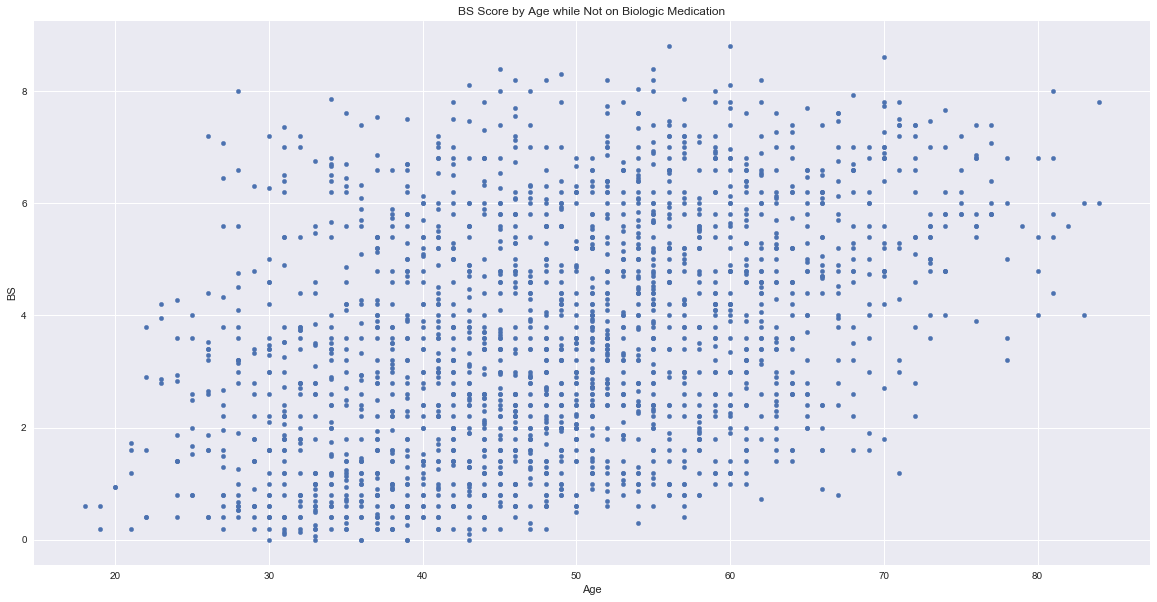

In [69]:
no_drugs_df_agg.reset_index().sample(2000).plot(kind='scatter', x='Age',y='BS', figsize=(20,10), title='BS Score by Age while Not on Biologic Medication')
plt.show()

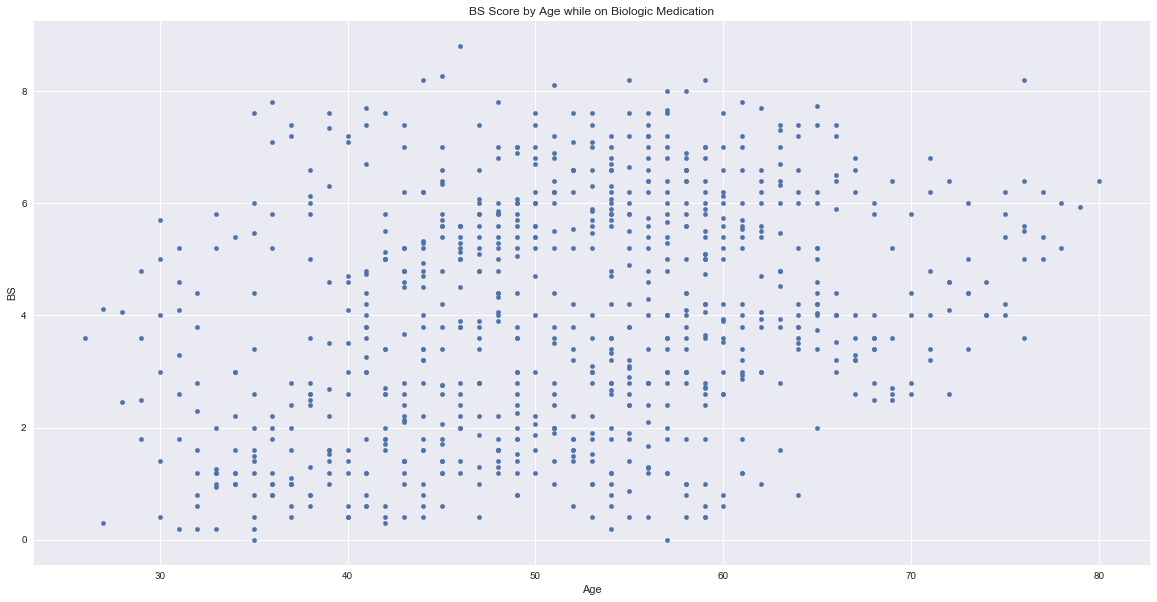

In [67]:
drugs_df_agg.reset_index().plot(kind='scatter', x='Age',y='BS', figsize=(20,10), title='BS Score by Age while on Biologic Medication')
plt.show()

In [68]:
drugs_df.shape

(1218, 8)